# Compute viewsheds

This notebook computes the viewshed for each point in 'observer_points' based on an 'elevation' raster.

This notebook uses GRASS GIS (7.0.4), and must be run inside of a GRASS environment (start the jupyter notebook server from the GRASS command line).
<a href="https://grass.osgeo.org">GRASS GIS</a>

The code in this notebook was modified from examples in "How to write a Python GRASS GIS 7 addon" developed for a FOSS4G Europe 2015 workshop. The code is contained in the <a href="https://github.com/wenzeslaus/python-grass-addon">"python-grass-addon"</a> repository on GitHub.com.

#### Required packages

<a href="https://github.com/numpy/numpy">numpy</a> <br />
<a href="https://github.com/pydata/pandas">pandas</a> <br />
<a href="https://github.com/rasbt/pyprind">pyprind</a>

#### Variable definitions

elevation – raster digital elevation model <br />
observer_points – vector map contain observer points <br />
observer_height – height in map units of observer above the elevation raster

In [ ]:
elevation = 'DEM'
observer_points = 'sample_points_field'
observer_elevation = 1.5

#### Import packages

In [1]:
import numpy as np
import pandas
import pyprind

GRASS import statements

In [2]:
import grass.script as gscript

from grass.pygrass.vector.geometry import Point
from grass.pygrass.vector import Vector

from grass.pygrass.vector import VectorTopo
from grass.pygrass.vector.table import DBlinks

#### Compute Viewshed

In [4]:
radius = -1  #default = -1 (infinity)

tmp_viewshed_name = 'tmp_viewshed'
tmp_point = 'tmp_current_point'

# connect to attributes table
sample_points = VectorTopo(observer_points)
sample_points.open(mode='r')
dblinks = DBlinks(sample_points.c_mapinfo)
link = dblinks[0]
sample_points_table = link.table()
sample_points_table.filters.select('cat', 'ID')

with Vector(observer_points, mode='r') as points:
    
    progress_bar = pyprind.ProgBar(points.n_lines, bar_char='█', title='Viewshed progress', monitor=True, stream=1, width=50)
    
    for point in points:
        progress_bar.update(item_id = str(point.cat))
        
        # get ID of point
        sample_points_table.filters.where('cat = {0}'.format(point.cat))
        cursor = sample_points_table.execute()
        result = np.array(cursor.fetchall())
        cursor.close()
        data = pandas.DataFrame(result, columns=['cat', 'ID']).set_index('cat')
        ID = data['ID'].get_value(point.cat)
        
        # compute viewshed
        viewshed_id = str(ID)
        viewshed_name = viewshed_id + '_viewshed'
        gscript.read_command('r.viewshed',
                             input=elevation,
                             observer_elevation=1.5,
                             output=tmp_viewshed_name,
                             coordinates=point.coords(),
                             overwrite=True)
        gscript.mapcalc(exp="{viewshed} = if({tmp}, {vid}, null())".format(viewshed=viewshed_name,
                                                                                  tmp=tmp_viewshed_name,
                                                                                  vid=viewshed_id),
                        overwrite=True)

Viewshed progress
0%                                     100%
[█████████████████████████████████████████] | ETA: 00:00:00 | Item ID: 41
Total time elapsed: 07:04:56


#### Utility functions

delete viewshed

In [ ]:
def delete_viewshed(name):
    gscript.read_command('g.remove',
                         type='raster',
                         name=name,
                         flags='f')

view result

In [ ]:
# import a function to render the results
from render import view

from grass.pygrass.modules.shortcuts import raster as r

# set the colors of the input and output maps to a predefined elevation color table
#r.colors(map='DEM', color='elevation')

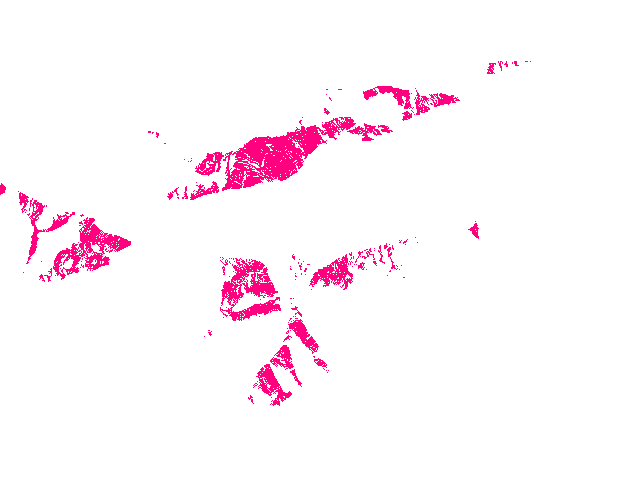

In [12]:
view(['8_viewshed'])